In [2]:
import os
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms,models
import torch.backends.cudnn as cudnn
import matplotlib .pyplot as plt
from itertools import permutations
from sklearn.model_selection import train_test_split
import math
from scipy.stats import gamma
import boto3
from io import BytesIO

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]

class CustomDataset(Dataset):
    def __init__(self, dataset, cmr=None, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(dataset):
            if cmr is not None:
                for index in cmr:
                    img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, label = self.data[idx], self.labels[idx]
        if self.transform is not None:
            data = self.transform(data)
        return data, label


['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


In [3]:
from torch.utils.data import ConcatDataset
from torch.utils.data.dataloader import default_collate

img_dim = 128
epochs = 50
batch_size = 2048
lr = 1e-3
input_size = 3 * 128 * 128
latent_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()])

def custom_collate(batch):
    inputs = [item[0] for item in batch]
    return default_collate(inputs)



data_dir = 'data/COCO/'
coco_train = datasets.CocoDetection(root=data_dir + 'train2014',
                            annFile=data_dir + 'annotations/instances_train2014.json',
                            transform=transform)
coco_val = datasets.CocoDetection(root=data_dir + 'val2014',
                          annFile=data_dir + 'annotations/instances_val2014.json',
                          transform=transform)
train_set = ConcatDataset([coco_train, coco_val])
print(len(train_set))

test_set = datasets.CocoDetection(root=data_dir + 'test2014',
                            annFile=data_dir + 'annotations/image_info_test2014.json',
                            transform=transform)
print(len(test_set))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

loading annotations into memory...
Done (t=5.35s)
creating index...
index created!
loading annotations into memory...
Done (t=2.98s)
creating index...
index created!
123287
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
40775


In [4]:
class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

# 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            Conv2dSame(3, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            Conv2dSame(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            Conv2dSame(128, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*(img_dim//8)*(img_dim//8), latent_size * 2)  # 输出均值和方差
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128*(img_dim//8)*(img_dim//8)),
            nn.ReLU(),
            nn.Unflatten(1, (128, img_dim//8, img_dim//8)),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # 编码
        latent_params = self.encoder(x)
        mu, logvar = torch.chunk(latent_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)

        # 解码
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [11]:
print(device)
model = VAE(latent_size=latent_size).to(device)

cuda


In [6]:
# 训练VAE模型

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean')
model.train()

for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        MSE = criterion(recon_batch, data)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = MSE + KLD
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader.dataset)}")

# 评估模型
model.eval()
test_loss = 0.0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += criterion(recon_batch, data).item()

test_loss /= len(test_loader.dataset)
print(f"Test set loss: {test_loss:.4f}")

Epoch 1/50, Loss: 0.0642545367448726
Epoch 2/50, Loss: 4.49369752544474e-05
Epoch 3/50, Loss: 3.891908207610898e-05
Epoch 4/50, Loss: 3.808469259027362e-05
Epoch 5/50, Loss: 3.7924538798734725e-05
Epoch 6/50, Loss: 3.919250582003362e-05
Epoch 7/50, Loss: 3.754535720362804e-05
Epoch 8/50, Loss: 3.801356304487353e-05
Epoch 9/50, Loss: 4.161454334280847e-05
Epoch 10/50, Loss: 3.756963469753624e-05
Epoch 11/50, Loss: 3.814833934438581e-05
Epoch 12/50, Loss: 3.725970409374158e-05
Epoch 13/50, Loss: 3.735122626990052e-05
Epoch 14/50, Loss: 4.128332401045801e-05
Epoch 15/50, Loss: 3.6822921987339395e-05
Epoch 16/50, Loss: 3.679095206070429e-05
Epoch 17/50, Loss: 3.7400754467787196e-05
Epoch 18/50, Loss: 3.717005938388001e-05
Epoch 19/50, Loss: 3.776089616029031e-05
Epoch 20/50, Loss: 3.714660262804708e-05
Epoch 21/50, Loss: 3.721971521587425e-05
Epoch 22/50, Loss: 3.7687591879570515e-05
Epoch 23/50, Loss: 3.7118536600898385e-05
Epoch 24/50, Loss: 3.70238782637486e-05
Epoch 25/50, Loss: 3.7324

In [7]:
torch.save(model.state_dict(), 'results/SelfOracle/COCO_VAE.pth')

In [12]:
criterion = nn.MSELoss(reduction='none')

test_loader = DataLoader(test_set, batch_size=4096, shuffle=False, collate_fn=custom_collate)

#将训练集的误差存起来
error_testing = []

model.load_state_dict(torch.load('results/SelfOracle/COCO_VAE.pth'))
model.to(device)
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon_batch, _, _ = model(data)
        batch_error = criterion(recon_batch, data)
        error_testing.extend([torch.mean(batch_error[i]).cpu().item() for i in range(batch_error.shape[0])])
        #print(len(error_testing))
        #print(error_testing)

print(error_testing)
#拟合一个分布
shape, loc, scale = gamma.fit(error_testing, floc=0)
false_alarm = 0.0001

#求出上百分之一分位数
threshold = gamma.ppf(1-false_alarm, shape, loc, scale)

print(threshold)
print(np.where(error_testing>threshold)[0].size)

[0.05952270328998566, 0.05183209106326103, 0.02142084762454033, 0.10457479953765869, 0.008440764620900154, 0.02754705771803856, 0.04975495859980583, 0.0450504831969738, 0.048677027225494385, 0.04961433634161949, 0.05910007655620575, 0.028233027085661888, 0.07516074925661087, 0.08149784058332443, 0.18088696897029877, 0.04118784889578819, 0.08672171831130981, 0.05787209793925285, 0.08123725652694702, 0.07769086211919785, 0.039731599390506744, 0.03912336379289627, 0.05207812786102295, 0.12202532589435577, 0.07935640215873718, 0.020641058683395386, 0.07333593815565109, 0.056066982448101044, 0.04338614642620087, 0.13442371785640717, 0.040891245007514954, 0.045396700501441956, 0.06927566975355148, 0.045922111719846725, 0.06112285703420639, 0.029965754598379135, 0.0850716233253479, 0.03146854788064957, 0.02655661851167679, 0.07490411400794983, 0.05456554889678955, 0.08387541770935059, 0.0339752621948719, 0.04550289735198021, 0.058585941791534424, 0.07076322287321091, 0.0723768100142479, 0.057

In [6]:
with open('results/SelfOracle/COCO_threshold.txt', 'w') as f:
    f.write(f'False_alarm: {false_alarm}\n')
    f.write(f'Tthreshold: {threshold}\n')

In [5]:
s3 = boto3.client(
    's3',
    aws_access_key_id='AK07YKEGEIA34PPJ6VZ6',
    aws_secret_access_key='Pr0efNjUwPlvJ8GinjyFjt7qb/I+3HLmneBXjFD6',
    endpoint_url='https://s3.nju.edu.cn'  # 根据您的信息填写正确的终端点
)

class S3CocoDetection(datasets.CocoDetection):
    def __init__(self, bucket, prefix, annFile, transform=None):
        super(S3CocoDetection, self).__init__(bucket, annFile, transform)
        self.s3 = s3
        self.bucket = bucket
        self.prefix = prefix

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # 确保路径指向images键下的文件
        key = os.path.join(self.prefix, file_name.split('.')[0]+'.png')
        
        # 从S3加载图片
        obj = self.s3.get_object(Bucket=self.bucket, Key=key)
        img = Image.open(BytesIO(obj['Body'].read())).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [ ]:
model = VAE(latent_size=latent_size).to(device)
model.load_state_dict(torch.load('results/SelfOracle/COCO_VAE.pth'))

criterion = nn.MSELoss(reduction='none')
batch_size = 8196
model.eval()
model.to(device)

chunk_size = 50
filename = 'results/SelfOracle/COCO_validity.npy'
result_selfOracle = {}
num = 0
if os.path.exists(filename):
    existed = np.load(filename,allow_pickle=True).item()
else:
    existed = {}
print(1)
for i in range(len(mrs)):
    for cmr in permutations(range(len(mrs)), i+1):
        if cmr != (0,):
            continue
        if cmr in existed.keys():
            continue

        result_selfOracle[cmr] = []
        bucket = 'hyw-husy'
        prefix = os.path.join('followup', ''.join([str(mr) for mr in cmr]))
        followup_test_set = S3CocoDetection(bucket=bucket, prefix=prefix, 
            annFile= 'data/COCO/' + 'annotations/image_info_test2014_followup.json', transform=transform)
        print(2)
        followup_test_loader = DataLoader(followup_test_set, batch_size=batch_size, 
            shuffle=False, collate_fn=custom_collate, num_workers=5)
        print(3)
        with torch.no_grad():
            for batch_idx, data in enumerate(followup_test_loader):
                data = data.to(device)
                print(4)
                recon, _, _ = model(data)
                print(5)
                error = criterion(recon, data)
                result_selfOracle[cmr].extend([torch.mean(error[i]).cpu().item() for i in range(error.shape[0])])
        print(cmr)

        num += 1
        if num == chunk_size:   
            result_selfOracle.update(existed)
            np.save(filename, result_selfOracle)
            existed = result_selfOracle
            num = 0
            result_selfOracle = {}

if len(result_selfOracle) != 0:
    result_selfOracle.update(existed)
    np.save(filename, result_selfOracle)


# check
print(len(np.load(filename, allow_pickle=True).item()))

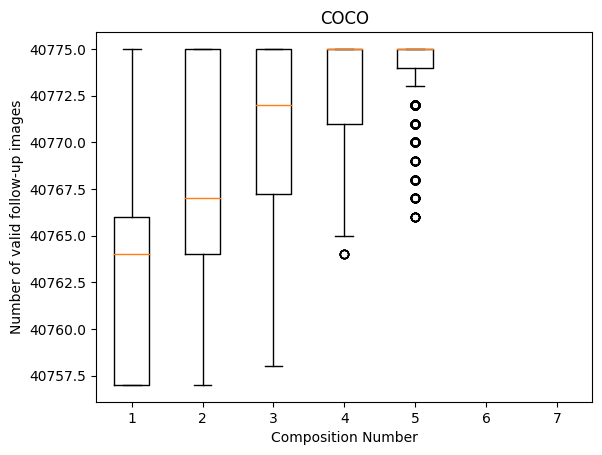

In [4]:
result_selfOracle = np.load('results/SelfOracle/COCO_validity.npy', allow_pickle=True).item()
#print(result_selfOracle)

th = 0.24528478258739284
data = [[] for _ in range(len(mrs))]
for cmr in result_selfOracle.keys():
    data[len(cmr)-1].append(len(np.where(np.array(result_selfOracle[cmr])<=th)[0]))

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
plt.title('COCO')
plt.xlabel('Composition Number')
plt.ylabel('Number of valid follow-up images')

plt.savefig('results/SelfOracle/COCO_validity.pdf', dpi=600)

# 显示图表
plt.show()
